In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import logging

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

## 1. Load expression data

The `transformation` value can be one of `"none"`, `"sqrt"` or `"log"`, which determines how the expression data should be transformed in order to reduce outlier influence.

In [14]:
data_path: str = "data/Athaliana.csv"
transformation: str = "log"

In [15]:
from my_gatai import Expression_data

expression_data = Expression_data.from_csv(data_path, 
                                           transformation=transformation)
expression_data.full

,Phylostratum,GeneID,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
0,0.665923,AT1G01040,7.684616,7.556010,7.050604,7.164274,6.909007,6.871068,7.436869
1,0.665923,AT1G01050,7.314562,7.505662,7.418366,7.356127,7.311433,7.017187,6.977893
2,0.749960,AT1G01070,7.101505,7.118018,6.846093,6.835850,6.762982,6.777881,6.797738
3,0.665923,AT1G01080,6.925517,6.843093,7.075249,7.193290,7.239676,7.161602,6.759557
4,0.665923,AT1G01090,9.343609,9.727893,10.444871,10.591035,10.937251,11.112170,8.958484
...,...,...,...,...,...,...,...,...,...
25091,0.665923,AT5G67200,6.582219,6.596070,6.671822,6.704642,6.771374,6.697534,6.620210
25092,0.994581,AT5G67245,7.033339,7.044566,6.939101,7.041862,7.070173,6.894573,7.046004
25093,0.665923,AT5G67280,6.596707,6.619658,6.559663,6.435686,6.595369,6.763085,6.652929
25094,0.665923,AT5G67380,9.597377,7.794810,7.809637,7.781770,7.522221,7.573009,8.544600


In [10]:
expression_data.p_matrix

,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
0,0.000024,0.000022,0.000014,0.000016,0.000012,0.000011,0.000018
1,0.000017,0.000020,0.000020,0.000019,0.000018,0.000013,0.000011
2,0.000015,0.000016,0.000012,0.000013,0.000012,0.000012,0.000011
3,0.000011,0.000011,0.000014,0.000016,0.000017,0.000015,0.000009
4,0.000127,0.000189,0.000404,0.000479,0.000686,0.000788,0.000083
...,...,...,...,...,...,...,...
25091,0.000008,0.000008,0.000009,0.000010,0.000011,0.000010,0.000008
25092,0.000019,0.000019,0.000018,0.000021,0.000021,0.000017,0.000018
25093,0.000008,0.000008,0.000008,0.000007,0.000009,0.000010,0.000008
25094,0.000164,0.000027,0.000029,0.000029,0.000023,0.000023,0.000055


In [16]:
expression_data.tai

Zygote      0.727488
Quadrant    0.727497
Globular    0.727246
Heart       0.727241
Torpedo     0.727098
Bent        0.726984
Mature      0.727283
dtype: float64

### 1.1 Compute TAI value

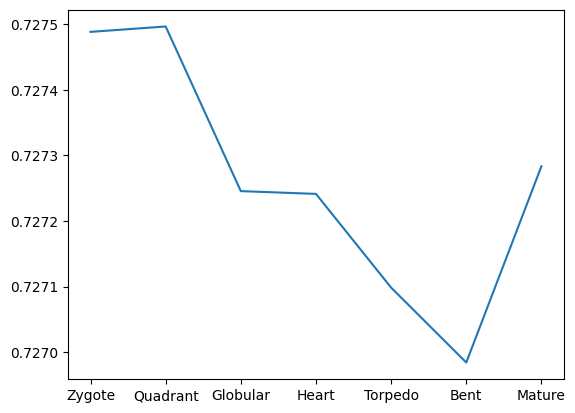

In [17]:
import matplotlib.pyplot as plt

plt.plot(expression_data.tai)
plt.show()

## 2. Flatline test

### 2.1. Compute variance of TAI curve

In [8]:
import numpy as np
tai_var = np.var(expression_data.tai).item()
tai_var

3.0198515687824144e-08

### 2.2. Compute permutation variance distribution

Permute the assigned gene ages between the genes to run the flat line test

In [9]:
from gatai.utils import comp_vars

num_permutations = 10000
permutation_comp_vars = comp_vars(expression_data, num_permutations)

Running permuations


100%|██████████| 10000/10000 [00:05<00:00, 1959.47it/s]


### 2.3. Fit the random variances to a Gamma distribution and compute the p-value of the true TAI

In [10]:
from flatline import fit_gamma, p_value_function

# NOTE: the default fitting method used by scipy doesn't achieve a very good fit, so use "MM"
a, loc, scale = fit_gamma(permutation_comp_vars)
get_p_value = p_value_function(a, loc, scale)
print("Gamma fit params:", a, loc, scale)

Gamma fit params: 0.8726671942061682 1.199955857361075e-10 6.172774574567844e-10


In [11]:
print("p-value of TAI:", get_p_value(tai_var))

p-value of TAI: 3.8343956162840936e-22


### 2.4. Visually compare the random TAI variances against the true one

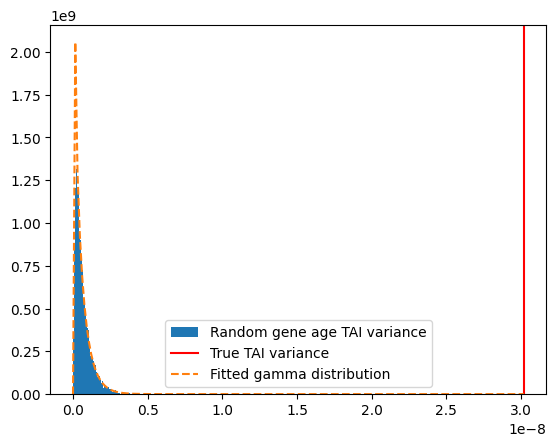

In [12]:
from scipy import stats
plt.hist(permutation_comp_vars, density=True, bins=100, label="Random gene age TAI variance")
plt.axvline(x=tai_var, label="True TAI variance", color="red")

x = np.linspace(0, tai_var, 200)
y = stats.gamma.pdf(x, a, loc=loc, scale=scale)
plt.plot(x, y, label="Fitted gamma distribution", linestyle="dashed")

plt.legend()
plt.show()

## 3. Destroy TAI signal with GATAI

### 3.0 Run greedy algorithm

2024-10-08 13:19:32,871 INFO:Step 0, Variance 3.0198515687813595e-08, P-value: 3.8343956163497605e-22
2024-10-08 13:19:32,872 INFO:tai vector: [ 2.25828199e-04  2.34065841e-04 -1.70199714e-05 -2.12608566e-05
 -1.64171848e-04 -2.78340683e-04  2.08993185e-05]


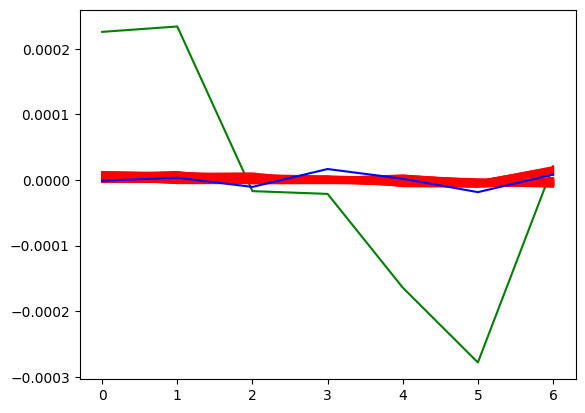

In [13]:
from greedy import projection_greedy


projection_genes = projection_greedy(expression_data, get_p_value, p_value_target=0.999999,top_k=200)

In [14]:
projection_genes

['AT1G56600',
 'AT2G07675',
 'AT2G18340',
 'AT2G25440',
 'AT2G43360',
 'AT4G22870',
 'AT5G42240',
 'AT2G22500',
 'AT2G25360',
 'AT3G08770',
 'AT3G61050',
 'AT4G36600',
 'AT4G37750',
 'AT5G20570',
 'AT5G41010',
 'AT5G59320',
 'AT1G02660',
 'AT1G51700',
 'AT5G05410',
 'AT1G52040',
 'AT5G25610',
 'AT1G24020',
 'AT1G48750',
 'AT5G17460',
 'AT5G48350',
 'AT1G17140',
 'AT2G26020',
 'AT3G17150',
 'AT4G17200',
 'AT4G32105',
 'AT5G42290',
 'AT2G16900',
 'AT1G12845',
 'AT1G56100',
 'AT3G15280',
 'AT1G56415',
 'AT1G71470',
 'AT2G30560',
 'AT3G06090',
 'AT3G16895',
 'AT3G24510',
 'AT3G49270',
 'AT3G49300',
 'AT3G50970',
 'AT4G27530',
 'AT4G29285',
 'AT5G09980',
 'AT5G42235',
 'AT5G64900',
 'AT1G53285',
 'AT1G75190',
 'AT3G13370',
 'AT5G53880',
 'AT1G52827',
 'AT5G67600']

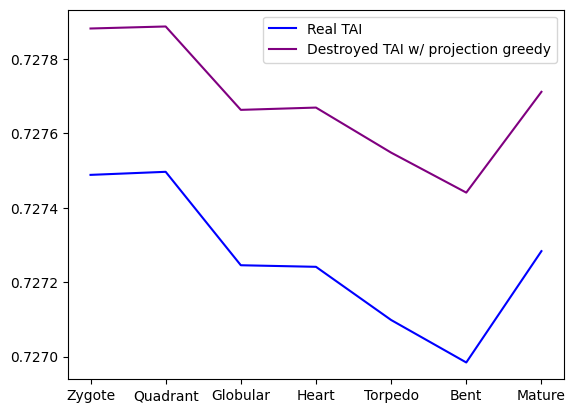

In [16]:
projection_data = expression_data.remove_genes(projection_genes)
plt.plot(expression_data.tai, label="Real TAI", color="blue")
plt.plot(projection_data.tai, label="Destroyed TAI w/ projection greedy", color="purple")

plt.legend()
plt.show()

In [17]:
np.var(projection_data.tai)

np.float64(2.2773352986366027e-08)

### 3.1 Run genetic algorithm to extract genes that break the pattern
Note that the transformation used for the expression data heavily influences the number of genes that get extracted, as well as the number of generations needed for convergence.

Also, with transformations applied, older genes are better represented

In [ ]:
from my_gatai import get_extracted_genes

ga_genes = get_extracted_genes(expression_data, permutation_comp_vars)

#### Genes extracted

In [ ]:
len(ga_genes)

In [ ]:
ga_genes

### 3.2 Check variance of destroyed TAI and its new p-value

In [ ]:
new_data = expression_data.remove_genes(ga_genes)
plt.plot(expression_data.tai, label="Real TAI", color="blue")
plt.plot(new_data.tai, label="Destroyed TAI", color="red")

plt.legend()
plt.show()

In [ ]:
new_tai_var = np.var(new_data.tai).item()
print("destroyed TAI p-value:", get_p_value(new_tai_var))

In [ ]:
plt.hist(permutation_comp_vars, density=True, bins=100, label="Random gene age TAI variance")
plt.axvline(x=tai_var, label="True TAI variance", color="red")


x = np.linspace(0, tai_var, 200)
y = stats.gamma.pdf(x, a, loc=loc, scale=scale)
plt.plot(x, y, label="Fitted gamma distribution", linestyle="dashed")
plt.axvline(x=new_tai_var, label="Destroyed TAI variance", color="black")
plt.legend()
plt.show()

### 3.3 Benchmark GA against greedy removal of genes with highest variance

In [ ]:
gene_variances = expression_data.gene_variances.sort_values('Variance', ascending=False)
gene_variances

In [16]:
k_top = len(ga_genes)

highest_var_genes = gene_variances.head(k_top)['GeneID'].to_numpy()

In [ ]:
greedy_data = expression_data.remove_genes(highest_var_genes)
plt.plot(expression_data.tai, label="Real TAI", color="blue")
plt.plot(new_data.tai, label="Destroyed TAI", color="red")
plt.plot(greedy_data.tai, label="Greedy TAI", color="green")

plt.legend()
plt.show()

In [ ]:
greedy_tai_var = np.var(greedy_data.tai).item()
print("p-value: ", get_p_value(greedy_tai_var))

Conversely, however, the genes that were extracted by GATAI tend to have a high variance (but they need to be carefully selected, it's not as simple as picking the most variant ones, hence the need for the GA approach)

In [ ]:
common_genes = np.intersect1d(ga_genes, highest_var_genes)

print("Number of GA selected genes which are also part of the top_k most variant subset of genes in the dataset:", len(common_genes), "out of", len(ga_genes))

### 3.4 Stability of solutions

There doesn't seem to be any way to set a seed for the computation run. This would be useful to have, to make results fully reproducible.

In [20]:
%%capture
gene_sets = []

for _ in range(3):
    genes = get_extracted_genes(expression_data, permutation_comp_vars)
    gene_sets.append(set(genes))

In [ ]:
from matplotlib_venn import venn3

venn3(gene_sets)
plt.title("Overlap of genes extracted from 3 different GATAI run")
plt.show()

#### Genes in common

In [ ]:
np.array(list(gene_sets[0] & gene_sets[1] & gene_sets[2]))